### Convolutional Neural Networks and Computer Vision with TensorFlow
In deep learning, many different kinds of model architectures can be used for different problems.
For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

Ex:
- Classify whether a picture of food contains pizza 🍕 or steak 🥩
- Detect whether or not an object appears in an image

#### Workflow
- Getting a dataset to work with
- Architecture of a convolutional neural network
- A quick end-to-end example
- Steps in modelling for binary image classification with CNNs
- Becoming one with the data
- Preparing data for modelling
- Creating a CNN model
- Fitting a model
- Evaluating a model
- Improving a model
- Making a prediction with a trained model

#### Get the data
Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes

> We're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random

In [2]:
# View an image
def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir+target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (384, 512, 3)


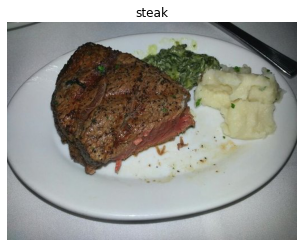

In [50]:
# View a random image from the training dataset
img = view_random_image(target_dir="data/pizza_steak/train/",
                        target_class="steak")

In [45]:
# View the image shape
img.shape # returns (width, height, colour channels)

(384, 512, 3)

### A (typical) architecture of a convolutional neural network
Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.

Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |


### An end-to-end example
We've checked out our data and found there's 750 training images, as well as 250 test images per class and they're all of various different shapes.

> Reading the [original dataset authors paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf), we see they used a [Random Forest machine learning model](https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d) and averaged `50.76%` accuracy at predicting what different foods different images had in them.

**From now on, that 50.76% will be our baseline.**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "data/pizza_steak/train/"
test_dir = "data/pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224x224
                                               class_mode="binary", # type of problem we're working here
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 7s 109ms/step - loss: 0.5948 - accuracy: 0.6827 - val_loss: 0.5008 - val_accuracy: 0.7120
Epoch 2/5
47/47 [==============================] - 5s 102ms/step - loss: 0.4406 - accuracy: 0.8047 - val_loss: 0.3993 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 5s 101ms/step - loss: 0.4212 - accuracy: 0.8073 - val_loss: 0.3993 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 5s 102ms/step - loss: 0.3774 - accuracy: 0.8440 - val_loss: 0.3417 - val_accuracy: 0.8740
Epoch 5/5
47/47 [==============================] - 5s 101ms/step - loss: 0.3216 - accuracy: 0.8740 - val_loss: 0.2877 - val_accuracy: 0.8720


In [6]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

### Using the same model
Now let's replicate the TensorFlow model.

In [7]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 5s 105ms/step - loss: 1.5417 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 101ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 101ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 101ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 101ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [8]:
# Check out our second model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


`model_2` has *602,141* trainable parameters where as `model_1` has only *31,101*.
And despite this difference, `model_1` still far and large out performs `model_2`.

> Note: Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the complexity of your model.

In [9]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
    tf.keras.layers.Dense(100, activation="relu"), # increase number of neurons from 4 to 100 (for each layer)
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"), # add an extra layer
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 5s 104ms/step - loss: 2.2450 - accuracy: 0.6400 - val_loss: 0.5557 - val_accuracy: 0.7580
Epoch 2/5
47/47 [==============================] - 5s 102ms/step - loss: 0.7698 - accuracy: 0.7027 - val_loss: 0.5593 - val_accuracy: 0.7460
Epoch 3/5
47/47 [==============================] - 5s 101ms/step - loss: 0.6998 - accuracy: 0.7260 - val_loss: 0.4760 - val_accuracy: 0.7820
Epoch 4/5
47/47 [==============================] - 5s 101ms/step - loss: 0.5960 - accuracy: 0.7653 - val_loss: 0.4216 - val_accuracy: 0.8020
Epoch 5/5
47/47 [==============================] - 5s 101ms/step - loss: 0.4575 - accuracy: 0.7940 - val_loss: 0.4835 - val_accuracy: 0.7620


In [10]:
# Check out model_3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


> The number of trainable parameters has increased even more than `model_2`.
And even with close to *500x* *(~15,000,000 vs. ~31,000)* more trainable parameters,
`model_3` still doesn't out perform `model_1`.

### Binary classification
- Preprocess the data (prepare it for a model)
- Create a model (start with a baseline)
- Fit the model
- Evaluate the model
- Adjust different parameters and improve model (try to beat your baseline)
- Repeat until satisfied

### Preprocess the data (prepare it for a model)
One of the most important steps for a machine learning project is creating a training and test set.
For an image classification project, it's standard to have your data seperated into `train` and `test` directories with subfolders in each for each class.

In [11]:
# Define directory dataset paths
train_dir = "data/pizza_steak/train/"
test_dir = "data/pizza_steak/test/"

In [12]:
# Create train and test data generators and rescale the data
# The ImageDataGenerator class helps us prepare our images
# into batches as well as perform transformations on them as they get loaded into the model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [13]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Create, compile and fit a model (start with a baseline)

In [14]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential


## Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 5s 103ms/step - loss: 1.6221 - accuracy: 0.6360 - val_loss: 0.4746 - val_accuracy: 0.8020
Epoch 2/5
47/47 [==============================] - 5s 101ms/step - loss: 0.4823 - accuracy: 0.7927 - val_loss: 0.3993 - val_accuracy: 0.8300
Epoch 3/5
47/47 [==============================] - 5s 101ms/step - loss: 0.4004 - accuracy: 0.8360 - val_loss: 0.3888 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 5s 102ms/step - loss: 0.2620 - accuracy: 0.9000 - val_loss: 0.4140 - val_accuracy: 0.8100
Epoch 5/5
47/47 [==============================] - 5s 101ms/step - loss: 0.1205 - accuracy: 0.9667 - val_loss: 0.4774 - val_accuracy: 0.8200


### Evaluate the model
Let's check out its training curves

In [15]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

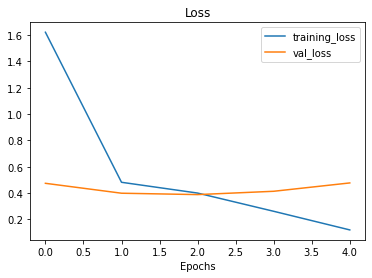

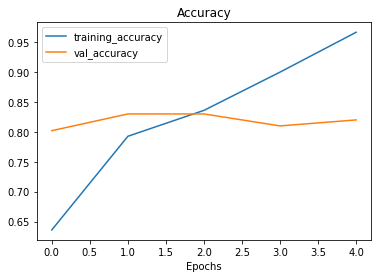

In [16]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

In [17]:
# Check out our model
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### Adjust the model parameters
Fitting a machine learning model comes in 3 steps:
1. Create a basline.
2. Beat the baseline by overfitting a larger model.
3. Reduce overfitting.

And there are even a few more things we could try to further overfit our model:

- Increase the number of convolutional layers.
- Increase the number of convolutional filters.
- Add another dense layer to the output of our flattened layer.

**So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.**

In [18]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation="sigmoid")
])

In [19]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [20]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 5s 104ms/step - loss: 0.6214 - accuracy: 0.6320 - val_loss: 0.4600 - val_accuracy: 0.7860
Epoch 2/5
47/47 [==============================] - 5s 102ms/step - loss: 0.4900 - accuracy: 0.7773 - val_loss: 0.4384 - val_accuracy: 0.8000
Epoch 3/5
47/47 [==============================] - 5s 104ms/step - loss: 0.4454 - accuracy: 0.8040 - val_loss: 0.3917 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 5s 105ms/step - loss: 0.4273 - accuracy: 0.8100 - val_loss: 0.4035 - val_accuracy: 0.8220
Epoch 5/5
47/47 [==============================] - 5s 102ms/step - loss: 0.4115 - accuracy: 0.8273 - val_loss: 0.4072 - val_accuracy: 0.8000


In [21]:
# Check out the model
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

This is effectively the `MaxPooling2D` layer taking the outputs of each `Conv2D` layer and saying:
"I only want the most important features, get rid of the rest".

The bigger the pool_size parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

*Check out the loss curves*:

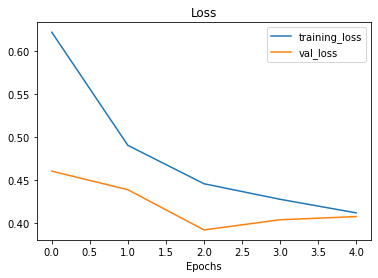

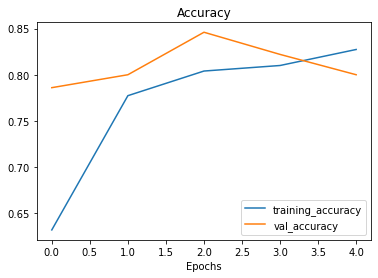

In [22]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

### Data augmentation
is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar. *Doing this simulates the kind of data a model might be used on in the real world.*

To implement data augmentation, we'll have to reinstantiate our `ImageDataGenerator` instances:

In [23]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [24]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [25]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

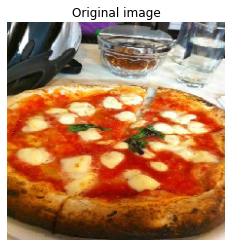

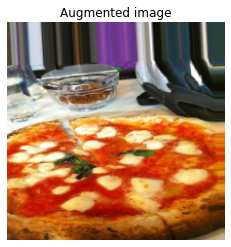

In [53]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

### Refit a model with augmented data and see how it affects training

In [27]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 14s 293ms/step - loss: 0.7037 - accuracy: 0.5473 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 13s 279ms/step - loss: 0.6965 - accuracy: 0.5073 - val_loss: 0.6542 - val_accuracy: 0.7660
Epoch 3/5
47/47 [==============================] - 13s 275ms/step - loss: 0.6663 - accuracy: 0.6413 - val_loss: 0.6029 - val_accuracy: 0.6680
Epoch 4/5
47/47 [==============================] - 13s 288ms/step - loss: 0.6380 - accuracy: 0.6693 - val_loss: 0.7530 - val_accuracy: 0.6000
Epoch 5/5
47/47 [==============================] - 14s 307ms/step - loss: 0.6232 - accuracy: 0.6660 - val_loss: 0.4659 - val_accuracy: 0.8360


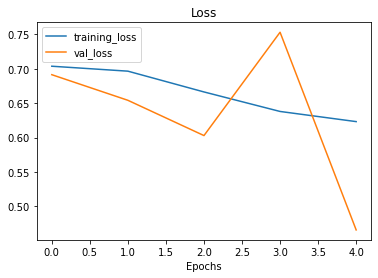

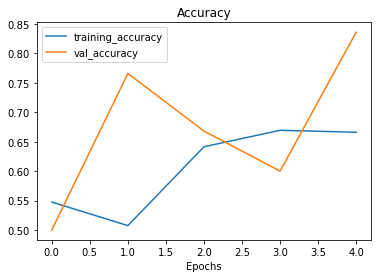

In [28]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

> It seems our validation loss curve is heading in the right direction but it's a bit jumpy (the most ideal loss curve isn't too spiky but a smooth descent, however, a perfectly smooth loss curve is the equivalent of a fairytale).

### Shuffle the augmented training data

In [29]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [30]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 15s 307ms/step - loss: 0.6337 - accuracy: 0.6253 - val_loss: 0.5386 - val_accuracy: 0.7060
Epoch 2/5
47/47 [==============================] - 13s 281ms/step - loss: 0.5093 - accuracy: 0.7553 - val_loss: 0.3533 - val_accuracy: 0.8580
Epoch 3/5
47/47 [==============================] - 13s 287ms/step - loss: 0.4616 - accuracy: 0.7813 - val_loss: 0.3845 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 13s 279ms/step - loss: 0.4575 - accuracy: 0.7813 - val_loss: 0.5174 - val_accuracy: 0.7580
Epoch 5/5
47/47 [==============================] - 13s 277ms/step - loss: 0.4600 - accuracy: 0.7993 - val_loss: 0.3588 - val_accuracy: 0.8460


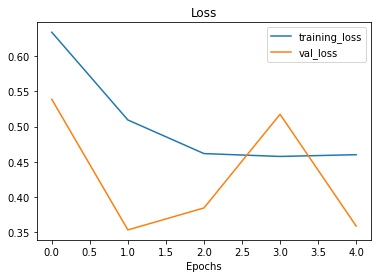

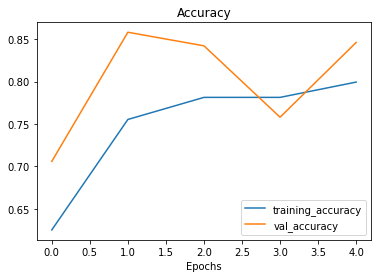

In [31]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

> Notice with `model_7` how the performance on the training dataset improves almost immediately compared to `model_6`. This is because we shuffled the training data as we passed it to the model using the parameter `shuffle=True` in the `flow_from_directory` method.

### Making a prediction with our trained model

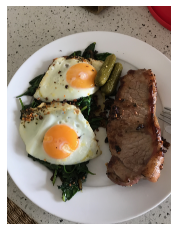

In [33]:
steak = mpimg.imread("data/pred/03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [34]:
steak.shape

(4032, 3024, 3)

In [35]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """ 
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.

    return img

In [36]:
# Load in and preprocess our custom image
steak = load_and_prep_image("data/pred/03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [37]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [38]:
pred = model_1.predict(steak)
pred

array([[0.91241825]], dtype=float32)

In [39]:
# Remind ourselves of our class names
import pathlib
import numpy as np
data_dir = pathlib.Path("data/pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [40]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [41]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

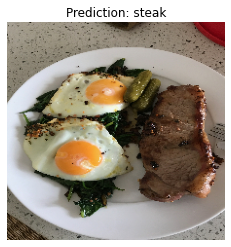

In [42]:
pred_and_plot(model_1, "data/pred/03-steak.jpeg", class_names)

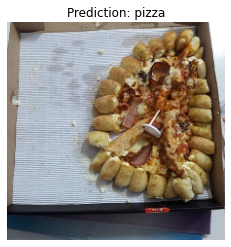

In [43]:
# Let's try one more image
pred_and_plot(model_1, "data/pred/04-pizza.png", class_names)

**The model was able to sort my messy pizza perfectly😀**